<a href="https://colab.research.google.com/github/rvignav/CT2Xray/blob/master/tests/baseline/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Using cached decorator-5.0.5-py3-none-any.whl (8.8 kB)


Using TensorFlow backend.


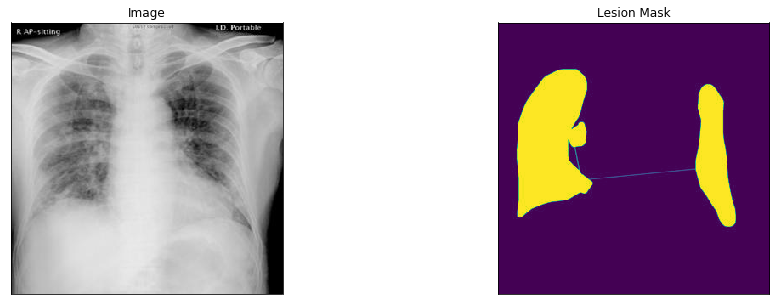

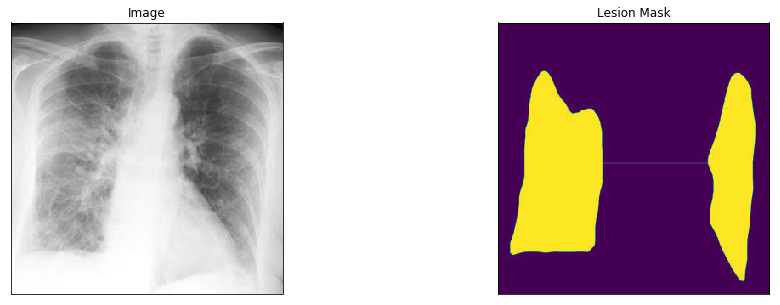

Segmentation Models: using `keras` framework.
58
Epoch 1/30
58/58 [==============================] - 27s 469ms/step - loss: -49.0711 - iou_score: 5.7525 - f1-score: 1.5252 - val_loss: -47.1135 - val_iou_score: 39.5312 - val_f1-score: 1.9084
Epoch 2/30
58/58 [==============================] - 3s 48ms/step - loss: -115.0598 - iou_score: 16.1986 - f1-score: 1.7343 - val_loss: -47.9368 - val_iou_score: 33.4875 - val_f1-score: 1.8941
Epoch 3/30
58/58 [==============================] - 3s 48ms/step - loss: -154.9489 - iou_score: 25.1236 - f1-score: 1.7942 - val_loss: -39.4389 - val_iou_score: 13.6303 - val_f1-score: 1.6242
Epoch 4/30
58/58 [==============================] - 3s 53ms/step - loss: -184.5986 - iou_score: 24.2134 - f1-score: 1.8207 - val_loss: -20.8465 - val_iou_score: 7.0346 - val_f1-score: 1.4569
Epoch 5/30
58/58 [==============================] - 3s 49ms/step - loss: -223.5746 - iou_score: 30.9657 - f1-score: 1.8502 - val_loss: -37.7201 - val_iou_score: 16.3401 - val_f1-score:

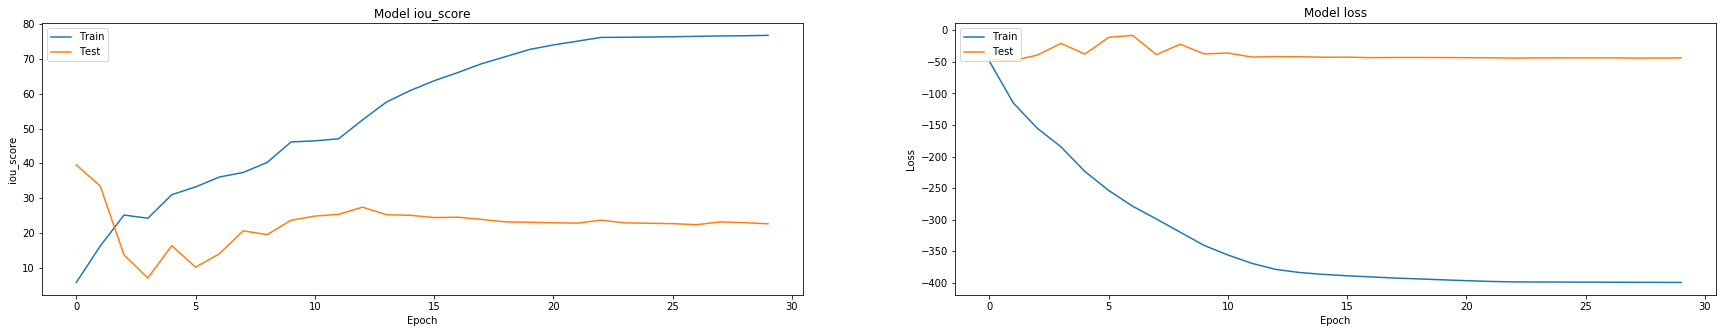

Loss: -47.937
mean iou_score: 33.488
mean f1-score: 1.8941


In [ ]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
import glob

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = './'

x_train_dir = os.path.join(DATA_DIR, 'images-train')
y_train_dir = os.path.join(DATA_DIR, 'masks-train')

x_valid_dir = os.path.join(DATA_DIR, 'images')
y_valid_dir = os.path.join(DATA_DIR, 'masks')

for i in glob.glob(x_train_dir + '/*.jpeg'):
    Image.open(i).resize((320,320)).convert('L').save(i)
for i in glob.glob(x_valid_dir + '/*.jpeg'):
    Image.open(i).resize((320,320)).convert('L').save(i)
for i in glob.glob(y_train_dir + '/*.jpeg'):
    Image.open(i).resize((320,320)).convert('L').save(i)
for i in glob.glob(y_valid_dir + '/*.jpeg'):
    Image.open(i).resize((320,320)).convert('L').save(i)

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

class Dataset:
    CLASSES = ['bg', 'lesion']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
    ):
        self.ids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.array(Image.open(self.masks_fps[i]).convert('L').resize((320,320)))
        mask = np.expand_dims(mask, axis=-1)
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

dataset = Dataset(x_train_dir, y_train_dir, classes=['lesion'])

image, mask = dataset[5]
visualize(
    image=image.squeeze(), 
    lesion_mask=mask.squeeze(),
)

import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)


dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'lesion'])

image, mask = dataset[12]
visualize(
    image=image.squeeze(), 
    lesion_mask=mask.squeeze(),
)

import segmentation_models as sm
BACKBONE = 'resnet18'
BATCH_SIZE = 1
CLASSES = ['lesion']
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'

model = sm.Unet(BACKBONE, input_shape=(320,320,3), classes=n_classes, activation=activation)
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
)

train_dataloader = Dataloader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

model.load_weights('best_model.h5') 

scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


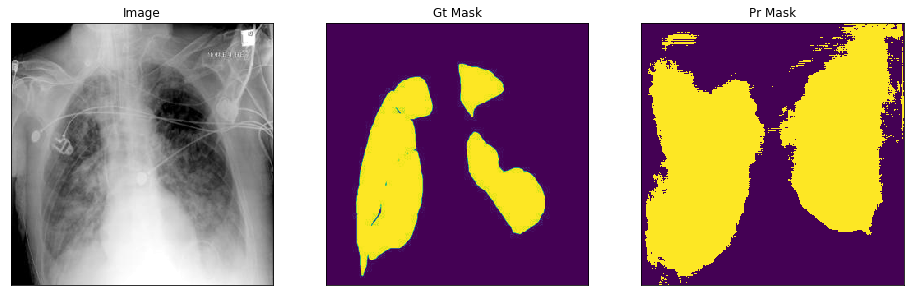

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


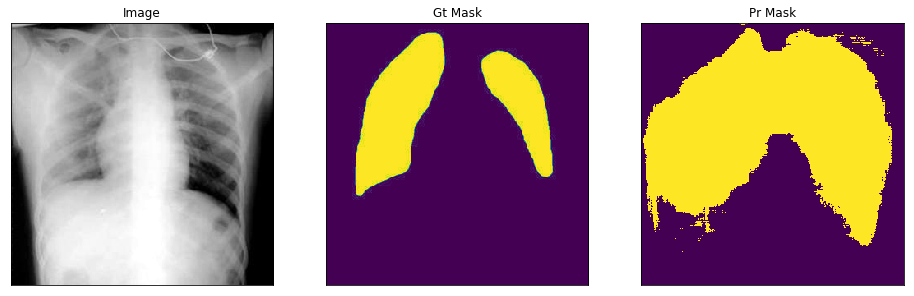

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


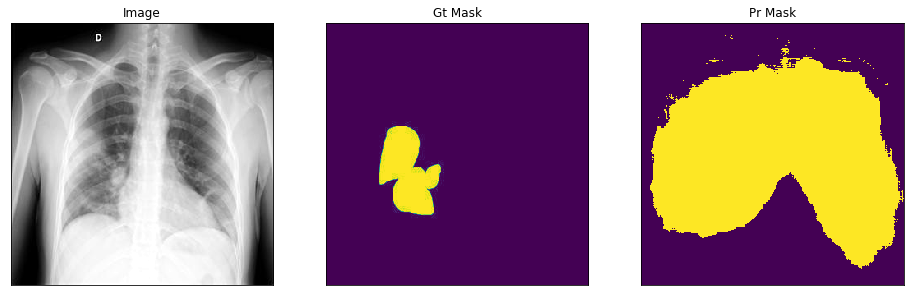

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


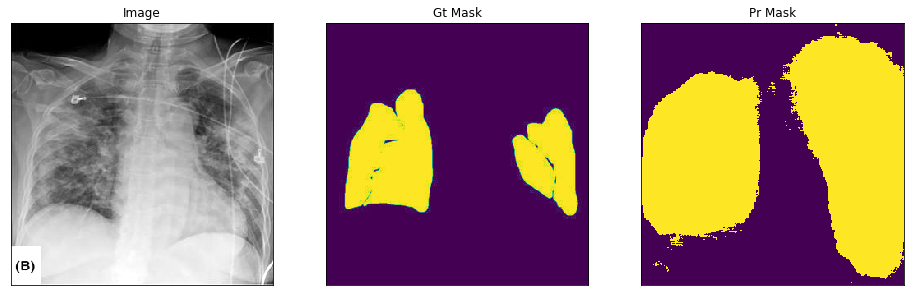

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


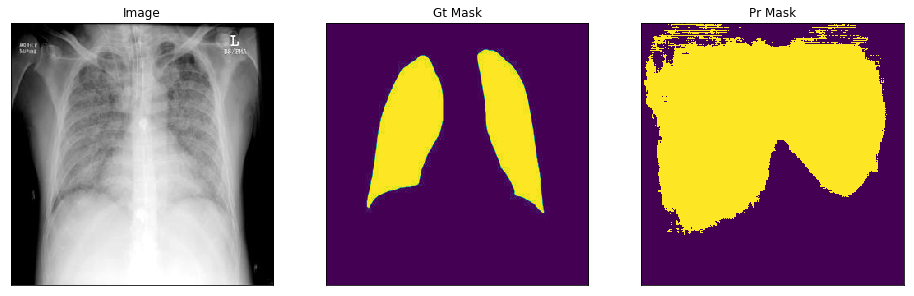

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


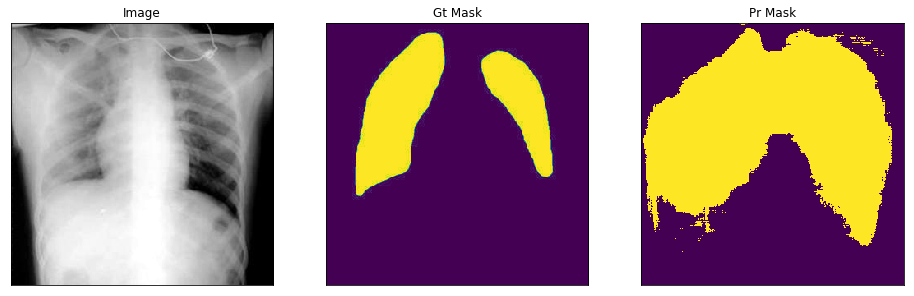

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


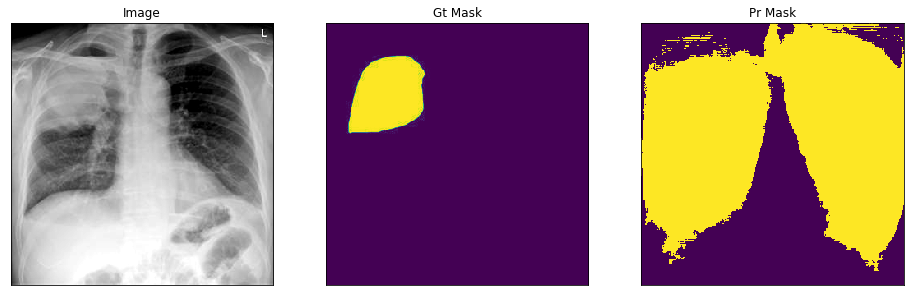

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


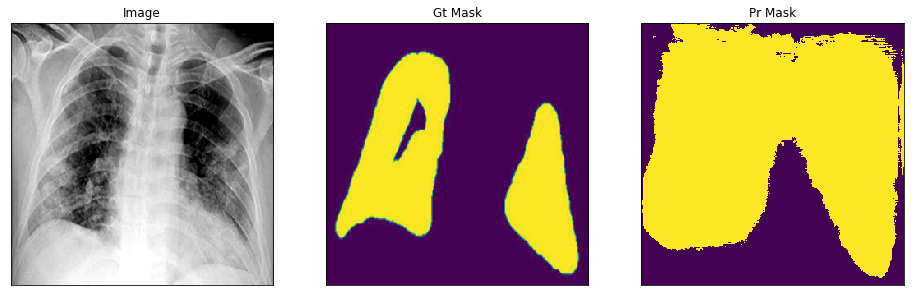

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


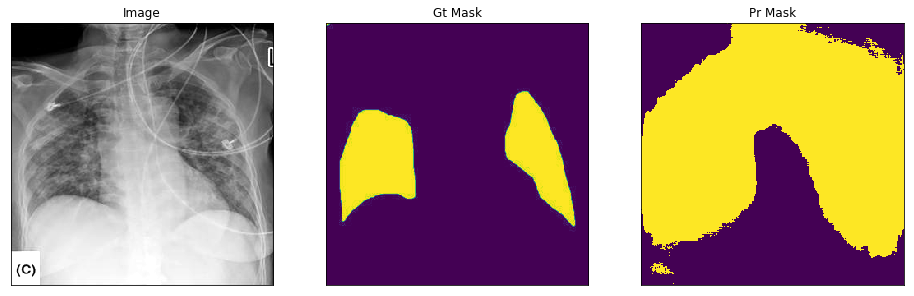

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


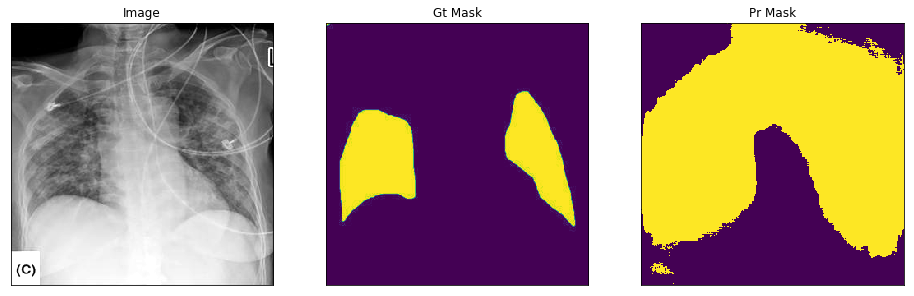

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


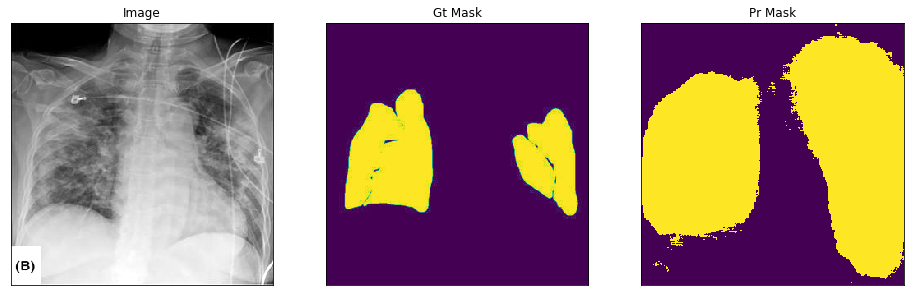

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


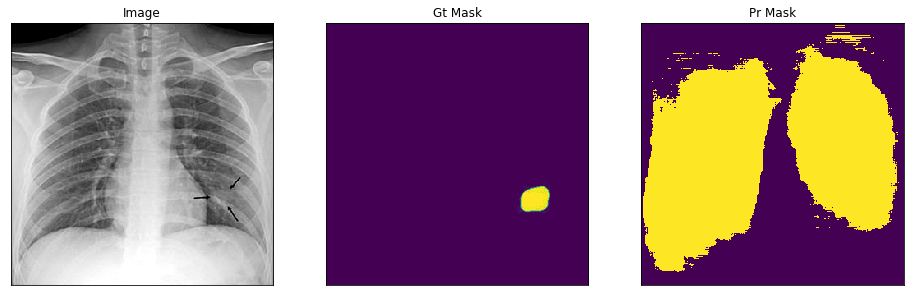

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


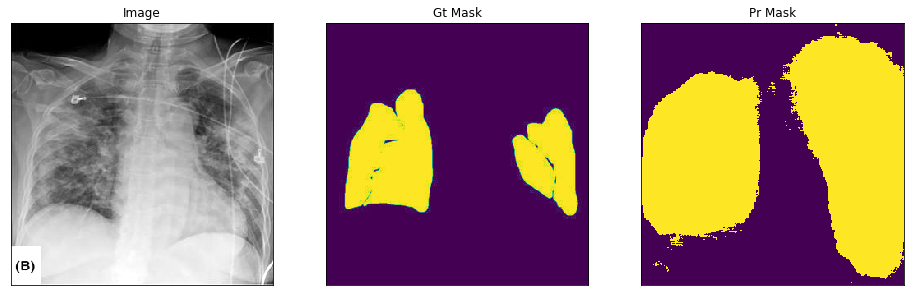

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


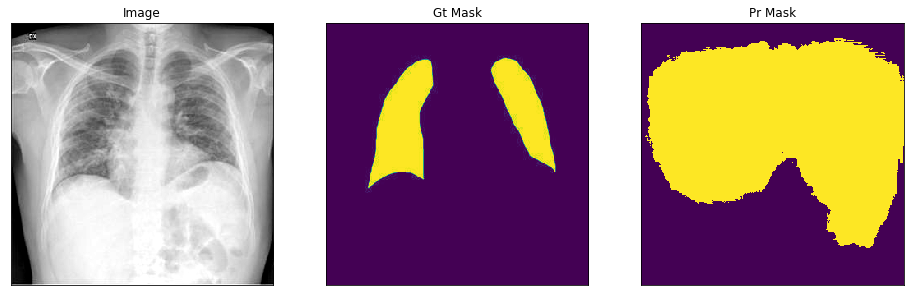

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


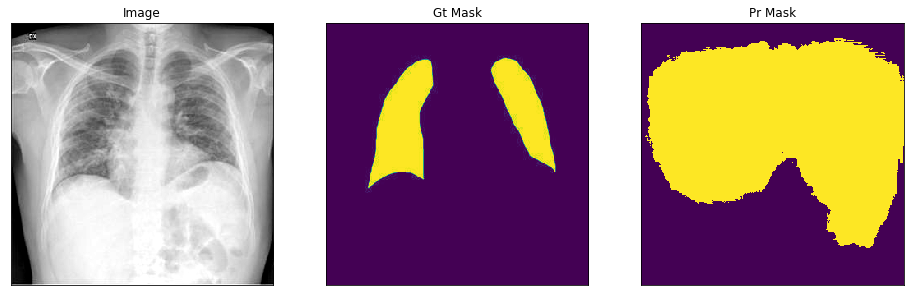

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


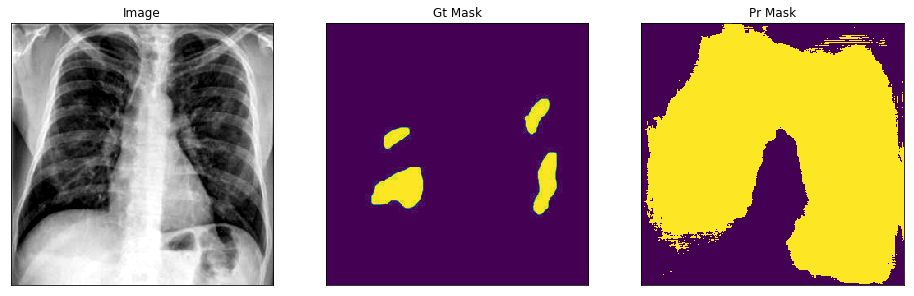

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


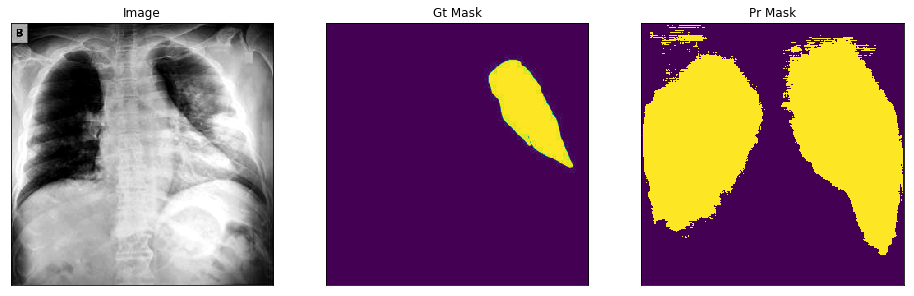

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


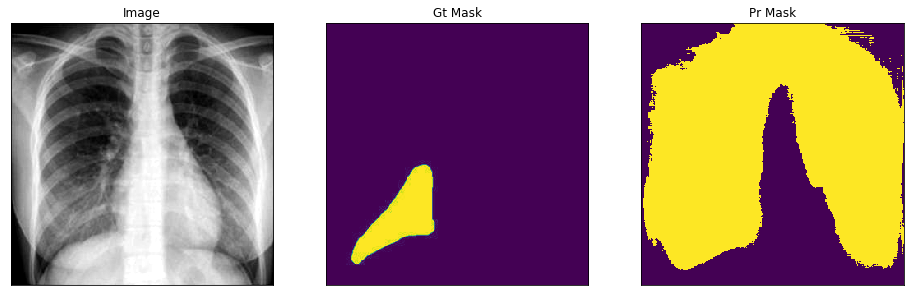

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


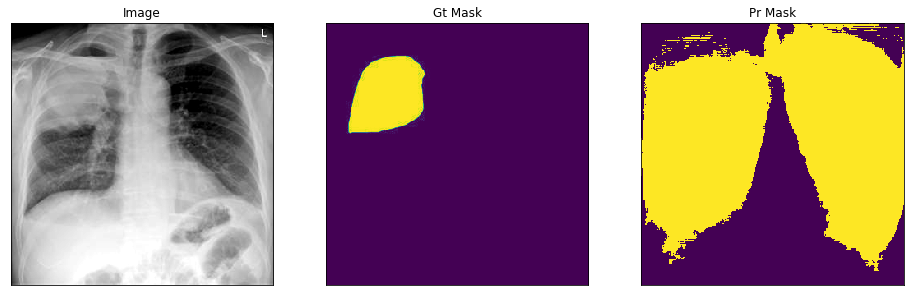

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


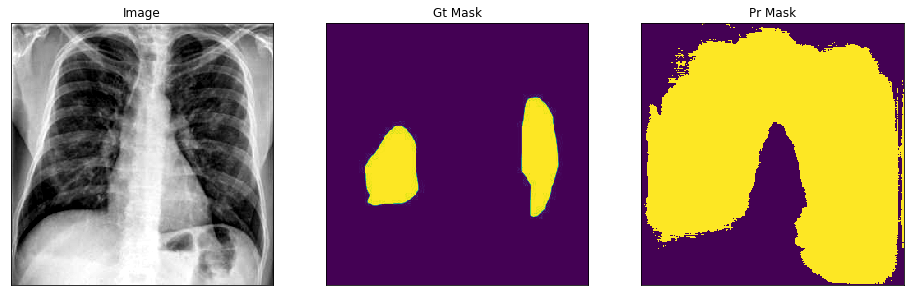

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


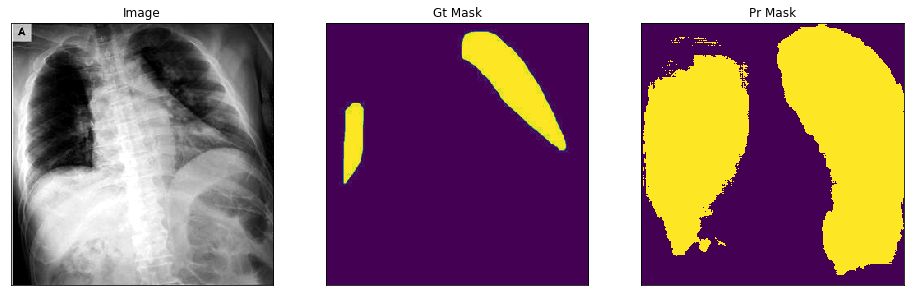

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


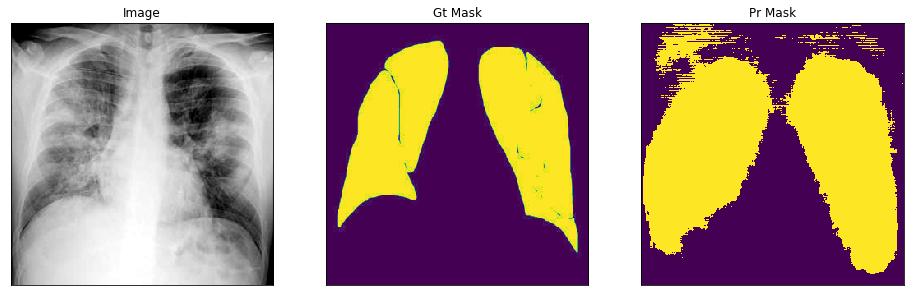

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


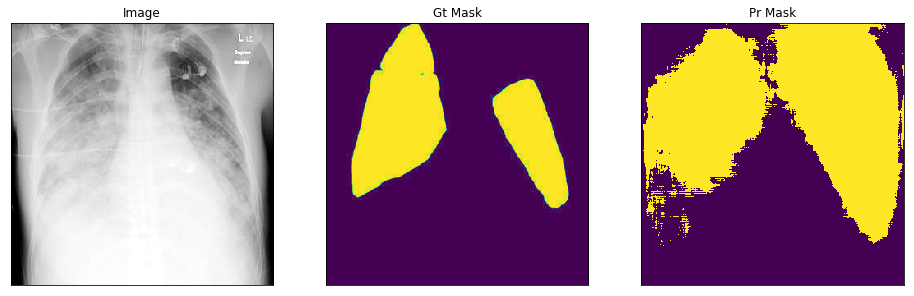

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


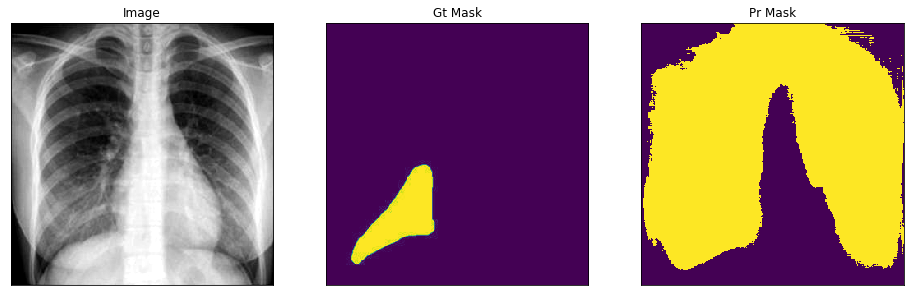

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


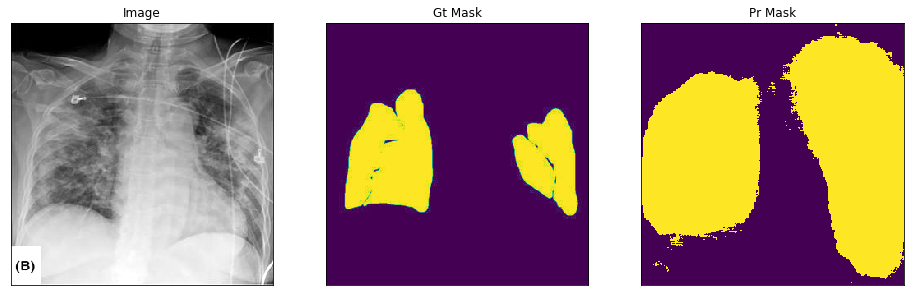

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


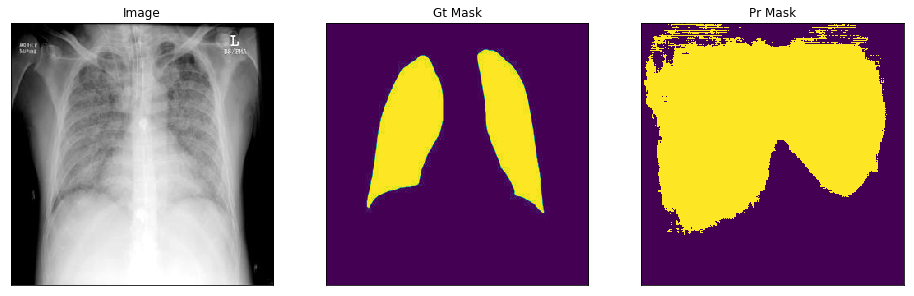

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


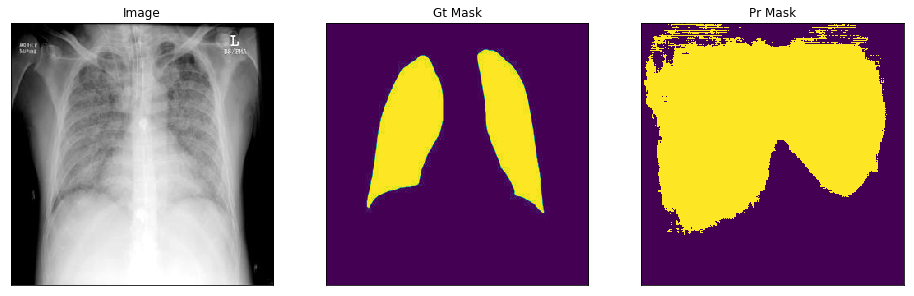

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


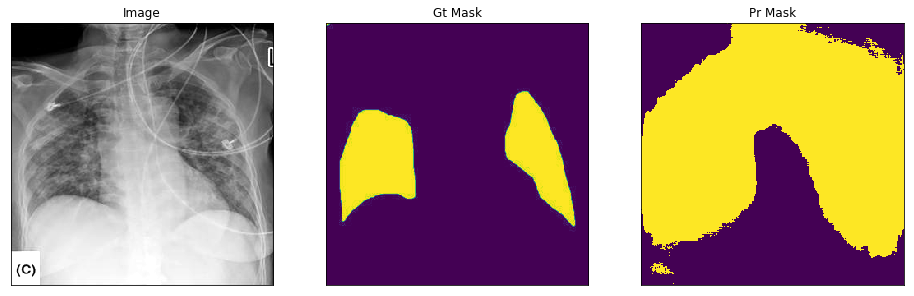

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


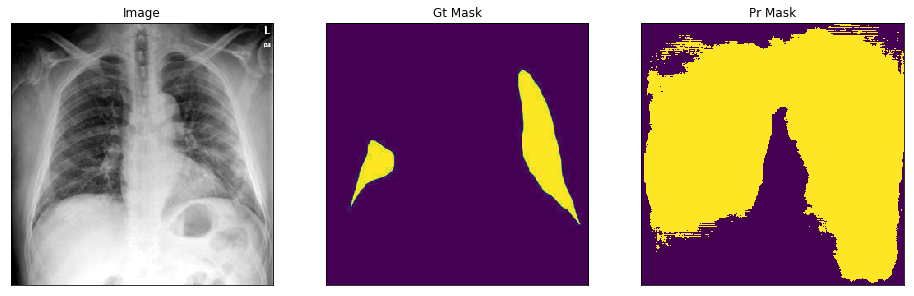

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


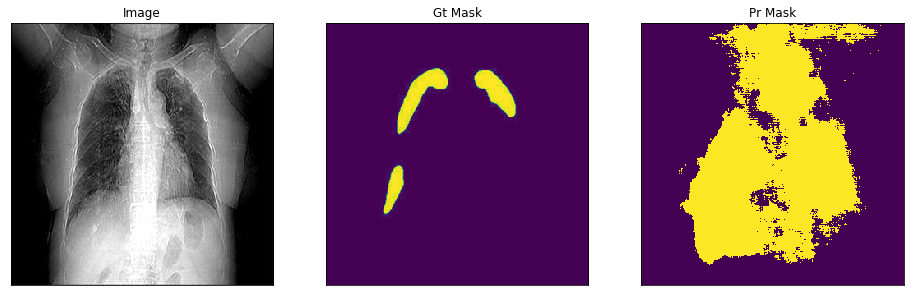

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


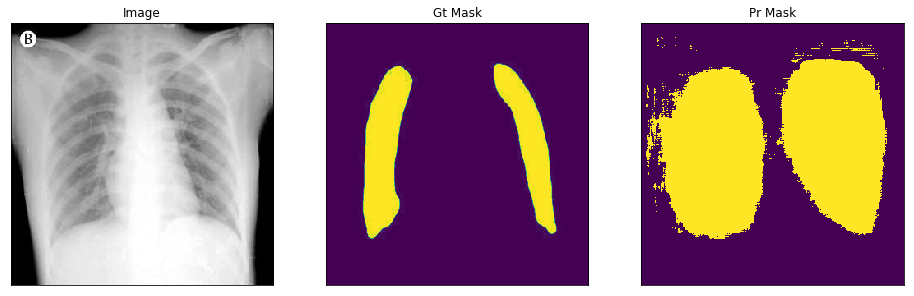

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


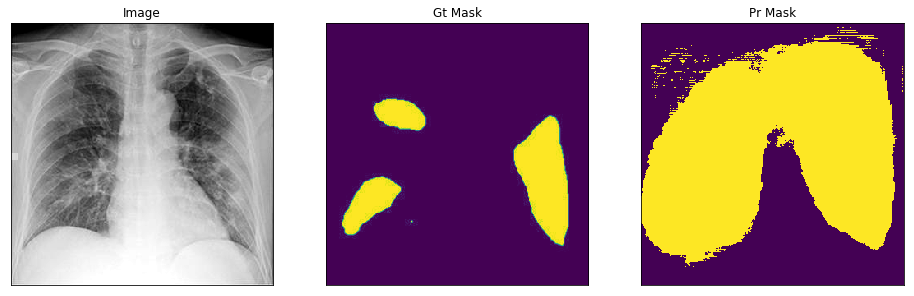

In [ ]:
n = 32
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
import imageio
import os
if not os.path.exists('pr_xro'):
    os.mkdir('pr_xro')
for q, i in enumerate(ids):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    gt_mask=gt_mask.squeeze()
    pr_mask=pr_mask.squeeze()

    imageio.imwrite('pr_xro/' + str(q) + '.png', pr_mask)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask,
        pr_mask=pr_mask,
    )